In [103]:
import numpy as np
from Strategy import Player
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy.stats import norm

In [69]:
experiment_data = pd.DataFrame(columns = ["Hands played", "Percent won", "Bet size", "Hit zero", "Percent per hour"])

In [14]:
try:
    experiment_data = pd.read_csv("experiment_data.csv")
except:
    experiment_data = pd.DataFrame(columns = ["Hands played", "Percent won", "Bet size", "Hit zero", "Percent per hour"])

In [70]:
class Deck():
    def __init__(self,):
        self.cards = ['2','3','4','5','6','7','8','9','10','J','Q','K','A']
        self.face_cards = ['J','Q','K']
    def draw(self,):
        card_drawn = np.random.choice(self.cards)
        return card_drawn

In [71]:
class BlackJack():
    def __init__(self, player):
        self.deck = Deck()
        self.hands_to_play = []
        self.dealer_public = None
        self.dealer_hidden = None
        self.bet = None
        self.hands_to_resolve = []
        self.player = player      
        self.bankrolls = []
    def deal(self, player_cards):
        if player_cards== None:
            player_hand = [self.deck.draw(), self.deck.draw()]
        else:
            player_hand = player_cards
        
        self.dealer_public = self.deck.draw()
        self.dealer_hidden = self.deck.draw()
        self.hands_to_play.append(player_hand)
        
        
    def reset(self, bet, player_cards = None):
        self.bet = bet
        self.bets = [bet]           
        self.player.bankroll -= self.bet
        self.deal(player_cards)
        return (self.hands_to_play, self.hands_to_resolve, self.dealer_public)
    
    def hand_to_value(self, hand):
        value = 0
        aces = 0
        for card in hand:
            if card in self.deck.face_cards:
                value = value + 10
            elif card == 'A':
                value = value + 11
                aces = aces + 1
            else:
                value = value + int(card)
        while (value > 21 and aces > 0):
            value = value - 10
            aces = aces - 1
        return value
    
    
    def dealer_hit_strategy(self, dealer_hand):
        dealer_score = self.hand_to_value(dealer_hand)
        
        if(dealer_score < 17):
            dealer_hand.append(self.deck.draw())
            return self.dealer_hit_strategy(dealer_hand)

        elif(dealer_score in range(17, 22)):
            return dealer_score, self.check_blackjack(dealer_hand), dealer_hand

        elif(dealer_score > 21):
            return 0, self.check_blackjack(dealer_hand), dealer_hand
    
    def check_blackjack(self, hand):
        value = self.hand_to_value(hand)
        if value == 21 and len(hand) == 2:
            return 1
        else:
            return 0
            
    def resolve(self, player_hand, dealer_score, dealer_has_blackjack):
        
        player_score = self.hand_to_value(player_hand)
        player_has_blackjack = self.check_blackjack(player_hand)
        
        if(self.check_player_bust(player_hand)):
            #print("player busts")
            return 0
        
        if(dealer_has_blackjack):
            if(player_has_blackjack):
                #print("push")
                return 1
            else:
                #print("player loses")      
                return 0
        
        if(player_score > dealer_score):
            if player_has_blackjack:
                #print("Blackjack")
                return 2.5
            else:
                #print("Player wins")
                return 2
        
        if(player_score == dealer_score):
            #print("push")
            return 1
        
        if(player_score < dealer_score):
            #print("player loses")
            return 0
           
    
    def check_player_bust(self, hand):
        value = self.hand_to_value(hand)
        if value > 21:
            return True
        else:
            return False

    def step_hand(self, action, player_hand):
        
        player_has_blackjack = self.check_blackjack(player_hand)
        
        if player_has_blackjack:
            return player_hand, 1
        
        else:
            if action == 'stand':
                return player_hand, 1
            
            elif action == 'hit':
                player_hand.append(self.deck.draw())
                is_player_bust = self.check_player_bust(player_hand)
                if is_player_bust:
                    return player_hand, 1
                else:
                    return player_hand, 0
                
            elif action == 'double':
                
                self.player.bankroll -= self.bet
                self.bet=self.bet * 2
                player_hand.append(self.deck.draw())
                
                return player_hand, 1
            
            elif action == 'split':
                
                assert len(player_hand) == 2, 'Player has more than two cards'
                assert player_hand[0] == player_hand[1], 'Player`s cards are different'
                self.player.bankroll -= self.bet
                if player_hand[0] == 'A':
                    self.hands_to_resolve.append([player_hand[0], self.deck.draw()])
                    self.hands_to_resolve.append([player_hand[0], self.deck.draw()])
                    self.bets.append(self.bet)
                    
                    self.hands_to_play.remove(player_hand)
                else:
                    self.hands_to_play.append([player_hand[0], self.deck.draw()])
                    self.hands_to_play.append([player_hand[0], self.deck.draw()])
                    
                
                return player_hand, 1
            
    def step(self):
        while(len(self.hands_to_play) > 0):
            for player_hand in self.hands_to_play:
                done = 0
                
                while not done:
                    action = self.player.choose_action(player_hand, self.dealer_public)
                    #print(action, player_hand)
                    player_hand, done = self.step_hand(action, player_hand)
                    
                    
              
                self.bets.append(self.bet)
                try:
                    self.hands_to_play.remove(player_hand)
                    self.hands_to_resolve.append(player_hand)
                except:
                    pass
                #print("final_hand:{}".format(player_hand))
                if action == 'double':
                    self.bet = self.bet/2
        #print([self.dealer_public, self.dealer_hidden])
        
        dealer_score, dealer_has_blackjack, dealer_hand = self.dealer_hit_strategy([self.dealer_public, self.dealer_hidden])
        #print(dealer_hand)
        #print(self.hands_to_resolve)
        while self.hands_to_resolve:
            player_hand=self.hands_to_resolve.pop()
           
            reward = self.resolve(player_hand, dealer_score, dealer_has_blackjack)
            self.player.bankroll += reward * self.bets.pop()
            self.bankrolls.append(self.player.bankroll)
        

In [112]:
def add_to_database():
    global experiment_data
    percent_won = 100 * (env.player.bankroll - initial_money)/initial_money
    percent_per_hour = percent_won/hands_num * 350
    new_experiment_data = [np.log10(hands_num), percent_won, bet_size, hit_zero, percent_per_hour]
    experiment_data = experiment_data.append(pd.Series(new_experiment_data, index = experiment_data.columns), ignore_index = 1)

In [113]:
initial_money = 100
hands_num = 10000 # will be saved as a power of ten
bet_size = 1 # percent

In [115]:
for exp_num in range(200):
    hit_min = 0
    env = BlackJack(Player(initial_money))
    for i in tqdm(range(hands_num)):
        this_bet = max(2, bet_size * env.player.bankroll / 100)
        if env.player.bankroll < 2:
            pass
        else:        
            env.reset(this_bet)
            env.step()
            if(env.player.bankroll < 0):
                hit_min = 1

    add_to_database()

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 19515.10it/s]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 22075.37it/s]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 21413.30it/s]


In [116]:
experiment_data.to_csv("experiment_data.csv", index = False)

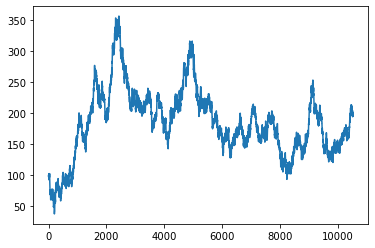

In [117]:
plt.plot(env.bankrolls)
plt.show()

In [118]:
x = experiment_data["Percent per hour"].values

(array([  1.,   0.,   1.,   2.,   4.,   5.,   7., 213., 105.,  62.,  73.,
         58.,  53.,  47.,  27.,  22.,  22.,  21.,  12.,  15.,   9.,   4.,
          6.,   5.,   4.,   6.,   3.,   5.,   3.,   2.,   1.,   0.,   2.,
          1.,   2.,   5.,   3.,   0.,   2.,   4.,   1.,   1.,   0.,   1.,
          2.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   0.,   1.,   0.,   0.,   2.,   0.,   0.,   0.,   1.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.]),
 array([-17.955     , -16.10575351, -14.25650702, -12.40726053,
        -10.55801404,  -8.70876755,  -6.85952105,  -5.01027456,
         -3.16102807,  -1.31178158,   0.53746491,   2.3867114 ,
          4.23595789,   6.08520438,   7.93445087,   9.78369736,
         11.63294386,  13.48219035,  15.33143684,  17.18068333

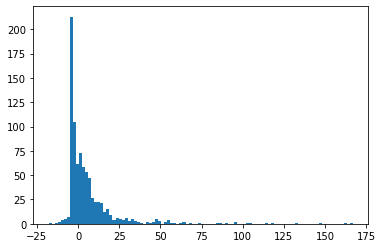

In [125]:
plt.hist(x, bins = 100)

In [120]:
x.std()

18.60627052711813

In [121]:
cdf_probability = norm.cdf(0, loc=x.mean(), scale=x.std())

In [122]:
1-cdf_probability

0.6358766220573098